In [195]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [196]:
!pip install tensorflow-text
!pip install tf-models-official
import pandas as pd
import numpy as np
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import string
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization
tf.get_logger().setLevel('ERROR') 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [197]:
def load_dataset():
  column_names = [ 'id', 'text', 'is_humor', 'humor_rating', 'humor_controversy', 'offense_rating' ]
  data_path = '/content/drive/My Drive/data-nlp-humor-offense/train.csv'
  data_frame = pd.read_csv(data_path, names=column_names, skiprows=1, na_values="?", sep=",", skipinitialspace=True)
  data = data_frame.fillna(0).to_numpy()

  return data, data_frame

In [198]:
result, df_result = load_dataset()
print(result[:5])

[[1
  "TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit..."
  1 2.42 1.0 0.2]
 [2
  'A man inserted an advertisement in the classifieds "Wife Wanted". The next day, he received 1000 of replies, all reading: "You can have mine." Free delivery also available at your door step'
  1 2.5 1.0 1.1]
 [3
  'How many men does it take to open a can of beer? None. It should be open by the time she brings it to the couch.'
  1 1.95 0.0 2.4]
 [4
  "Told my mom I hit 1200 Twitter followers. She pointed out how my brother owns a house and I'm wanted by several collection agencies. Oh ma!"
  1 2.11 1.0 0.0]
 [5
  'Roses are dead. Love is fake. Weddings are basically funerals with cake.'
  1 2.78 0.0 0.1]]


In [199]:
train_data, train_labels = [], []
val_data, val_labels = [], []
test_data, test_labels = [], []

humor_yes_data, humor_yes_labels = [], []
humor_no_data, humor_no_labels = [], []

for i in range(0, len(df_result['is_humor'])):
  if df_result['is_humor'][i] == 1:
    humor_yes_data.append(df_result['text'][i])
    humor_yes_labels.append(df_result['is_humor'][i])
  else:
    humor_no_data.append(df_result['text'][i])
    humor_no_labels.append(df_result['is_humor'][i])

output_bias = np.log([len(humor_yes_data)/len(humor_no_data)])

yes_total = len(humor_yes_labels)
no_total = len(humor_no_data)
p75_yes = int(0.75 * yes_total)
p75_no = int(0.75 * no_total)

train_data_temp = np.concatenate((humor_yes_data[:p75_yes], humor_no_data[:p75_no]))
train_labels_temp = np.concatenate((humor_yes_labels[:p75_yes], humor_no_labels[:p75_no]))

test_data_temp = np.concatenate((humor_yes_data[p75_yes:], humor_no_data[p75_no:]))
test_labels_temp = np.concatenate((humor_yes_labels[p75_yes:], humor_no_labels[p75_no:]))

train_keys = []
test_keys = []

result_train_map = {}
for index in range(0,len(train_data_temp)):
  result_train_map[index] = {'text': train_data_temp[index], 'label': train_labels_temp[index]}
  train_keys.append(index)

result_test_map = {}
for index in range(0, len(test_data_temp)):
  result_test_map[index] = {'text': test_data_temp[index], 'label': test_labels_temp[index]}
  test_keys.append(index)

random.shuffle(train_keys)
random.shuffle(test_keys)

for key in train_keys:
  train_data.append(result_train_map[key].get('text'))
  train_labels.append(result_train_map[key].get('label'))

for key in test_keys:
  test_data.append(result_test_map[key].get('text'))
  test_labels.append(result_test_map[key].get('label'))

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

d = {'text': train_data, 'label': train_labels}
train_dataset = pd.DataFrame(data=d)

d = {'text': test_data, 'label': test_labels}
test_dataset = pd.DataFrame(data=d)

In [200]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
# 'albert_en_base'
# 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

#  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [201]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [202]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [203]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [204]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.42972383]], shape=(1, 1), dtype=float32)


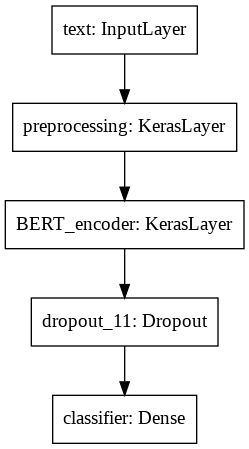

In [205]:
tf.keras.utils.plot_model(classifier_model)

In [206]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [207]:
train_ds = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_dataset['text'].values, tf.string, name='sentences'),
            tf.cast(train_dataset['label'].values, tf.int32, name='sentences')
        )
    )
)

test_ds = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test_dataset['text'].values, tf.string, name='sentences'),
            tf.cast(test_dataset['label'].values, tf.int32, name='sentences')
        )
    )
)

In [208]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
# optimizer=tf.keras.optimizers.SGD(learning_rate=0.000001, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.00001)

In [209]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [210]:
print(f'Training model with {tfhub_handle_encoder}')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto')
with tf.device('/GPU:0'):
  history = classifier_model.fit(train_dataset['text'].values,train_dataset['label'].values, epochs=50, validation_split=0.25, verbose=1, callbacks=callback)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/50
141/141 [==============================] - 67s 377ms/step - loss: 0.4793 - binary_accuracy: 0.7375 - val_loss: 0.2530 - val_binary_accuracy: 0.9047
Epoch 2/50
141/141 [==============================] - 52s 370ms/step - loss: 0.1534 - binary_accuracy: 0.9411 - val_loss: 0.2133 - val_binary_accuracy: 0.9227
Epoch 3/50
141/141 [==============================] - 52s 371ms/step - loss: 0.0695 - binary_accuracy: 0.9814 - val_loss: 0.2442 - val_binary_accuracy: 0.9207
Epoch 4/50
141/141 [==============================] - 52s 371ms/step - loss: 0.0417 - binary_accuracy: 0.9868 - val_loss: 0.2634 - val_binary_accuracy: 0.9293


In [211]:
with tf.device('/GPU:0'):
  loss, accuracy = classifier_model.evaluate(test_dataset['text'].values, test_dataset['label'].values, verbose=1)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

63/63 [==============================] - 8s 134ms/step - loss: 0.2335 - binary_accuracy: 0.9350
Loss: 0.23346510529518127
Accuracy: 0.9350000023841858
